 Importing Stuff

In [1]:
from glob import glob
import json
from os.path import sep
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from skimage import future
import pickle as pkl
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import RF_segmentation as rf
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.insert(1, r"C:\Users\chloe\DE4\Masters\masters-code\ReportFigures")

import validationimages as vi



styling figures

In [2]:
matplotlib.rcParams.update({'font.size': 12, "font.family": "Times New Roman", 
                            'figure.figsize': [3.6, 3.6], 'figure.dpi': 100, 'savefig.dpi': 300})

Defining parameters for grid search

In [3]:
gs_images = 10
folder = r'C:\Users\chloe\DE4\Masters\RandomForest_Models\GS2'
gsname = f'HLS_imgs_{gs_images}'

estimator_range = np.linspace(1,200, 10, dtype=int)
depth_range = np.linspace(1, 30, 10, dtype=int)

metrics = [rf.dice_coef, rf.mean_iou, confusion_matrix]



Creating training Data and test data

In [4]:


train_images = np.array(glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data' + sep + '*_i*'))
train_masks = np.array(glob(r'C:\Users\chloe\DE4\Masters\Dataset\Training_Data' + sep + '*_s*')) 

files = rf.rand_unique(gs_images, train_images, train_masks)

long_img = rf.stich_images(files[:,0])
long_mask = rf.stich_images(files[:,1], mask= True)

test_images = np.array(glob(r'C:\Users\chloe\DE4\Masters\Dataset\RF_validation' + sep + '*_i*'))
test_masks = np.array(glob(r'C:\Users\chloe\DE4\Masters\Dataset\RF_validation' + sep + '*_s*'))


training_features

In [5]:
training_features = rf.features_func(long_img)

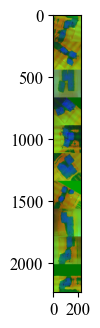

In [18]:
plt.imshow(long_img)
plt.show()

# Performing Grid Serch

In [ ]:
met_dict_a, met_dict_b = rf.grid_search(
    estimator_range=estimator_range,
    depth_range=depth_range,
    features=training_features, train_mask=long_mask,
    test_images=test_images,
    test_masks=test_masks,
    save_path=folder, name = gsname,
    metrics = metrics

)

with open(folder + sep + 'GS_metrics.json', 'w') as f:
    json.dump(met_dict_b, f)


In [ ]:
with open(folder + sep + 'GS_metrics.json', 'w') as f:
    json.dump(met_dict_b, f)


In [ ]:
with open(r"C:\Users\chloe\DE4\Masters\RandomForest_Models\GS2\GS_metrics.json", 'r') as f:
    met_dict = json.load(f)

dice_mat = np.array(met_dict['dice_coef'])


max_args = np.unravel_index(dice_mat.argmax(), dice_mat.shape)
print(max_args)
print(depth_range[max_args[1]], estimator_range[max_args[0]])



# Generating plots

In [ ]:
x = np.arange(20).reshape(5, 4)
print(x)
plt.imshow(x)
print(met_dict_a['dice_coef'])

In [ ]:

met_avg = np.mean((met_dict_a['dice_coef'], met_dict_a['mean_iou']), axis=0)
plt.plot(met_dict_a['dice_coef'][6][2:])
plt.show()

plt.figure()
plt.imshow(met_dict_a['dice_coef'][1:,3:], cmap = 'inferno', interpolation='bicubic', origin='lower',   aspect='auto', extent=[min(depth_range[3:]), max(depth_range[3:]),min(estimator_range[1:]), max(estimator_range[1:])])
cbar =plt.colorbar()
cbar.ax.set_ylabel('Dice Coefficient')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')





max_args = np.unravel_index(met_dict_a['dice_coef'].argmax(), met_dict_a['dice_coef'].shape)
print(depth_range[max_args[1]], estimator_range[max_args[0]])

plt.savefig(folder + sep + 'Grid_Search_nest_1-200_mdep_1-30.pdf', bbox_inches="tight")
plt.show()

Taking Best Model and Retraining

In [ ]:
num_images = 30 

files = rf.rand_unique(num_images, train_images, train_masks)

long_img = rf.stich_images(files[:,0])
long_mask = rf.stich_images(files[:,1], mask= True)
feats = rf.features_func(long_img)



In [ ]:
clf = RandomForestClassifier(n_estimators=estimator_range[max_args[0]], max_depth=depth_range[max_args[1]])
clf = future.fit_segmenter(long_mask, feats, clf)

with open(r'C:\Users\chloe\DE4\Masters\RandomForest_Models' + sep + 'model_' + 'GS2' + f'_nest_{estimator_range[max_args[0]]}_mdep_{depth_range[max_args[1]]}.pkl', 'wb') as f:
    pkl.dump(clf, f)

save_dict = {}

for k, mfunc in enumerate(metrics):
    met = rf.mean_metric(mfunc, test_images, test_masks, clf)
    
    if not isinstance(met,float):
        met = met.tolist()
    save_dict[mfunc.__name__] = met

with open(r'C:\Users\chloe\DE4\Masters\RandomForest_Models' + sep + 'metas_' + 'GS2' + f'_nest_{estimator_range[max_args[0]]}_mdep_{depth_range[max_args[1]]}.json', 'w') as f:
    json.dump(save_dict, f)


More Plots

In [6]:
with open(r"C:\Users\chloe\DE4\Masters\RandomForest_Models\model_GS1_nest_155_mdep_17.pkl", 'rb') as f:
    clf = pkl.load(f)

In [78]:

big = rf.open_img(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\14_03_16_07_42_47_8_i.tif")
big_mask = rf.open_mask(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\14_03_16_07_42_47_8_s.tif")
big_feats = rf.features_func(big)
big_pred = future.predict_segmenter(big_feats, clf)

small = rf.open_img(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\5_02_24_21_28_52_8_i.tif")
small_mask = rf.open_mask(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\5_02_24_21_28_52_8_s.tif")
small_feats = rf.features_func(small)
small_pred = future.predict_segmenter(small_feats, clf)

normal = rf.open_img(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\9_03_09_08_08_02_8_i.tif")
normal_mask = rf.open_mask(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\9_03_09_08_08_02_8_s.tif")
normal_feats = rf.features_func(normal)
normal_pred = future.predict_segmenter(normal_feats, clf)

lighting = rf.open_img(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\8_03_08_07_31_58_8_i.tif")
lighting_mask = rf.open_mask(r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\8_03_08_07_31_58_8_s.tif")
lighting_feats = rf.features_func(lighting)
lighting_pred = future.predict_segmenter(lighting_feats, clf)


In [89]:
def plot_comp(img, mask, pred, hls = True):
    if hls:
        img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    fig, axes = plt.subplots(ncols = 3, )

    fig.set_figwidth(7.2)
    fig.set_figheight(2)


    axes[0].imshow(img)
    axes[0].set_xlabel('Raw Image')
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_xlabel('Ground Truth')
    axes[2].imshow(pred, cmap="gray")
    axes[2].set_xlabel('Prediction')

    for i, ax in enumerate(axes):
        axes[i].tick_params(
            axis='both',          # changes apply to the voth axis
            which='both', 
            left = False,   # both major and minor ticks are affected
            right = False,
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        
        axes[i].xaxis.set_ticklabels([])
        axes[i].yaxis.set_ticklabels([])

        for j in ax.spines:
            axes[i].spines[j].set_visible(False)


0.9185280641466208


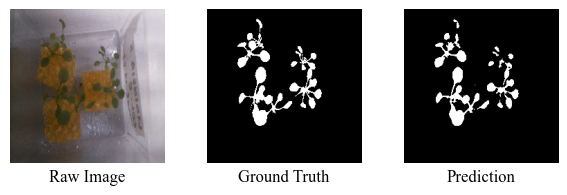

0.7557894736842106
0.833937928254736


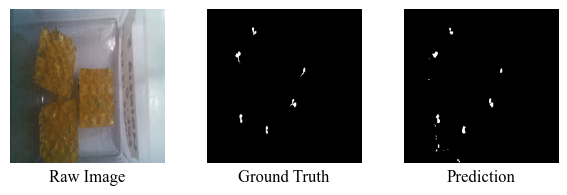

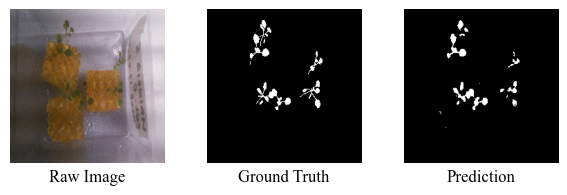

0.5369822485207101


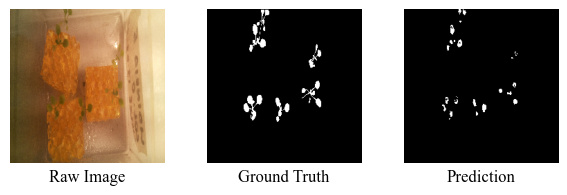

In [90]:
print(rf.dice_coef(big_mask-1, big_pred-1))
plot_comp(big, big_mask, big_pred)
# plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_big_growth.pdf', dpi =300)
plt.show()

print(rf.dice_coef(small_mask-1, small_pred-1))
plot_comp(small, small_mask, small_pred)
# plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_small_growth.pdf', dpi =300)


print(rf.dice_coef(normal_mask-1, normal_pred-1))
plot_comp(normal, normal_mask, normal_pred)
plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_medium_growth.pdf', bbox_inches='tight', dpi =300)
plt.show()

print(rf.dice_coef(lighting_mask-1, lighting_pred-1))
plot_comp(lighting, lighting_mask, lighting_pred)
plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_diff_lighting.pdf', bbox_inches='tight', dpi =300)
# plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_diff_lighting.pdf', dpi =300)


In [10]:

images = [
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\4_02_23_17_58_19_8_i.tif",
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\9_03_09_08_08_02_8_i.tif",
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\19_03_26_11_30_20_8_i.tif"
          ]

masks = [
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\4_02_23_17_58_19_8_s.tif",
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\9_03_09_08_08_02_8_s.tif",
    r"C:\Users\chloe\DE4\Masters\Dataset\RF_validation\19_03_26_11_30_20_8_s.tif"
]

3it [00:00,  3.75it/s]
3it [00:00, 99.13it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step


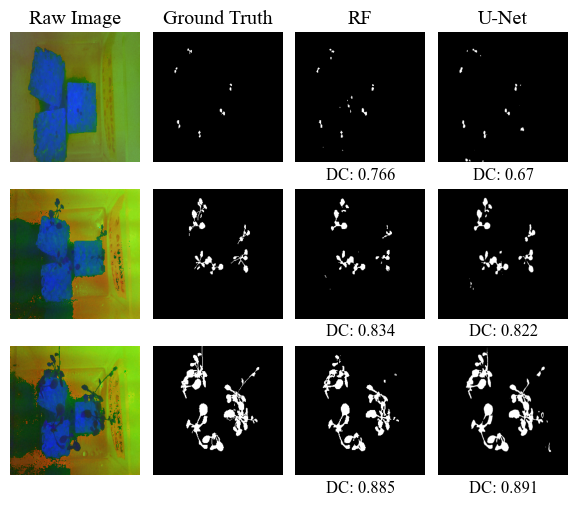

In [11]:
import matplotlib.gridspec as grid

cn_imgs = vi.get_imgs(images, hls=False, resolution=[512,512])
cn_masks = vi.get_imgs(masks, mask=True, resolution=[512,512])

loaded_model = keras.models.load_model(r"C:\Users\chloe\DE4\Masters\Models\Model_17.keras", compile=False)

fig = plt.figure(figsize=[7.2,7.2])
gs = grid.GridSpec(3, 4, fig, wspace = 0.1, hspace=-0.35)

results = loaded_model.predict(cn_imgs / 255)
results = results > 0.5

for i, (img, mask, result) in enumerate(zip(images, masks, results)):
    img = rf.open_img(img)
    img_feats = rf.features_func(img)
    mask = rf.open_mask(mask)

    result = np.reshape(result, (512,512))
    
    rf_pred = future.predict_segmenter(img_feats, clf)
    
    axes = []

    axes.append(fig.add_subplot(gs[i,0]))
    # img = cv2.cvtColor(img, cv2.COLOR_HLS2RGB)
    axes[0].imshow(img)

    axes.append(fig.add_subplot(gs[i,1]))
    axes[1].imshow(mask, cmap = 'gist_gray')

    axes.append(fig.add_subplot(gs[i,2]))
    axes[2].imshow(rf_pred, cmap = 'gist_gray')
    dc = rf.dice_coef(mask - 1, rf_pred - 1)
    axes[2].set_xlabel(f'DC: {float(f"{dc:.3g}")}')

    axes.append(fig.add_subplot(gs[i,3]))
    axes[3].imshow(result, cmap = 'gist_gray')
    dc = rf.dice_coef(cn_masks[i]/255, result)
    axes[3].set_xlabel(f'DC: {float(f"{dc:.3g}")}')
    
    if i == 0:
        twin_axes = []
        axes[0].set_title('Raw Image')
        axes[1].set_title('Ground Truth')
        axes[2].set_title('RF')
        axes[3].set_title('U-Net')


    for j, ax in enumerate(axes):

        axes[j].tick_params(
            axis='both',          # changes apply to the voth axis
            which='both', 
            left = False,   # both major and minor ticks are affected
            right = False,
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        
        axes[j].xaxis.set_ticklabels([])
        axes[j].yaxis.set_ticklabels([])

        for k in ax.spines:
            axes[j].spines[k].set_visible(False)
plt.savefig(r'C:\Users\chloe\DE4\Masters\Figures\big_compare.pdf')
plt.show()



In [65]:
image_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\All_Data\**\*_8.tif', recursive=True)[1:]

date_list = []
for i in image_files:
    spl = i.split(sep)[-1].split('_')
    dstring = "".join(spl[0:-1])
    date_list.append(dstring)

sorted_args = np.argsort(date_list)

image_files = np.array(image_files)[sorted_args]



In [66]:
cn_imgs = vi.get_imgs(image_files, hls=False, resolution=[512,512])

preds = loaded_model.predict(cn_imgs/ 255)


rf_imgs = vi.get_imgs(image_files, resolution=[224,224])



149it [09:58,  4.02s/it]


5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step


149it [08:35,  3.46s/it]


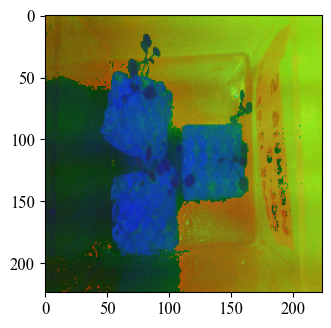

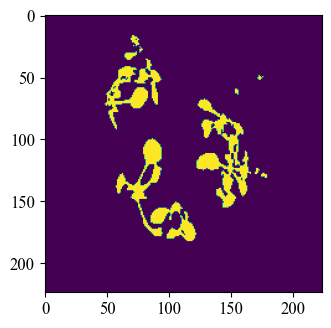

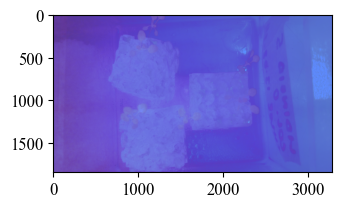

In [67]:

img = rf.open_img(images[1])
img_feats = rf.features_func(img)

plt.imshow(img)
plt.show()

try_img = rf.open_img(image_files[50])
try_img = cv2.cvtColor(try_img, cv2.COLOR_RGB2HLS)
# feats = rf.features_func(try_img)

feats_working = rf.features_func(img)

working_pred = future.predict_segmenter(feats, clf)
why_img = rf_imgs[100]
plt.imshow(rf_pred)
plt.show()
plt.imshow(try_img)
plt.show()




In [68]:
from tqdm import tqdm
result = preds > 0.5
rf_areas = []
cn_areas = []
for i, img  in tqdm(enumerate(rf_imgs)):
    feats = rf.features_func(img/255)
    rf_pred = future.predict_segmenter(feats, clf)

    rf_areas.append(np.sum(rf_pred - 1))

    p = np.reshape(result[i], (512,512))
    cn_areas.append(np.sum(p))



149it [06:34,  2.65s/it]


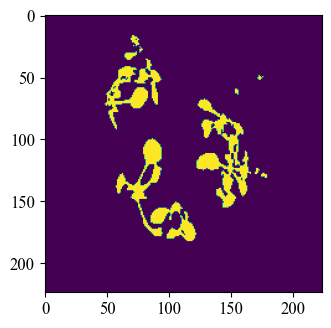

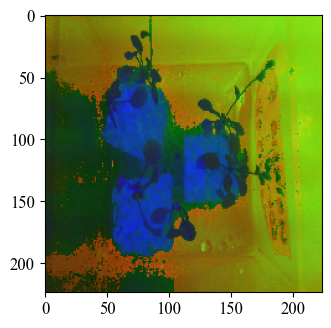

In [69]:
plt.imshow(rf_pred)
plt.show()
plt.imshow(img)
plt.show()

149 149


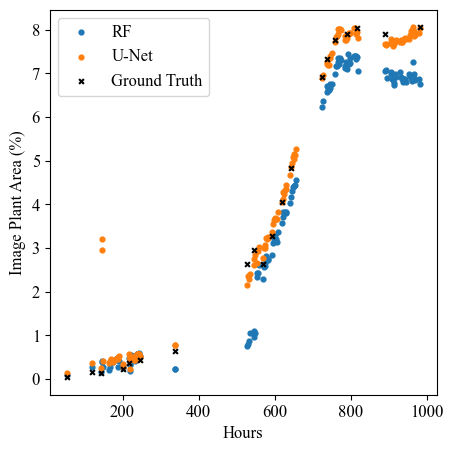

In [88]:
feb_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\All_Data\02**\*_8.tif', recursive=True)[1:]
mar_files = feb_files = glob(r'C:\Users\chloe\DE4\Masters\Dataset\All_Data\03**\*_8.tif', recursive=True)

first_day = int(feb_files[0].split(sep)[-1].split('_')[1])
first_hour = int(feb_files[0].split(sep)[-1].split('_')[2])

hours = []
for i in image_files:
    day = int(i.split(sep)[-1].split('_')[1])
    hour = int(i.split(sep)[-1].split('_')[2])
    month = int(i.split(sep)[-1].split('_')[0])
    hours.append( ((month - 2)*29 - first_day)*24 + (day - first_day)*24 + hour - first_hour)

gt_masks = glob(r'C:\Users\chloe\DE4\Masters\Dataset\RF_validation\*_s*')
val_hours = []
val_areas = []
for i in gt_masks:
    mask = rf.open_mask(i) - 1
    val_areas.append(np.sum(mask)/mask.size)
    day = int(i.split(sep)[-1].split('_')[2])
    hour = int(i.split(sep)[-1].split('_')[3])
    month = int(i.split(sep)[-1].split('_')[1])
    val_hours.append( ((month - 2)*29 - first_day)*24 + (day - first_day)*24 + hour - first_hour)

print(len(hours), len(rf_areas))

fig = plt.figure(figsize=[5,5])
plt.scatter(hours,100*np.array(rf_areas)/ 224**2, s = 12, label = 'RF')
plt.scatter(hours,100*np.array(cn_areas) / 512**2, s = 12, label = 'U-Net')
plt.scatter(val_hours, 100*np.array(val_areas), s = 12,  marker = 'x', color = 'black', label = 'Ground Truth')
plt.xlabel('Hours')
plt.ylabel('Image Plant Area (%)')
plt.legend()
plt.savefig(rf'C:\Users\chloe\DE4\Masters\Figures\rf_unet_leafarea.pdf', bbox_inches='tight',dpi=300)
plt.show()